# 몬테카를로 시뮬레이션
몬테카를로 알고리즘을 어떻게 효율적으로 구현할 수 있을까??

세가지 방식
- 순수 파이썬 구현
- Numpy를 사용한 벡터화
- 완전 벡터화

## 유러피안 콜 옵션 가격을 구하기 위한 몬테카를로 알고리즘
1. 구간 [0, T]를 간격 Delta t로 등분할한다.

2. i = I 로부터 다음과 같이 I번 샘플 경로를 생성한다
   a. 모든 시간 간격 t in {Delta t, 2Delta t ,,, T}에 대해 적용할 의사 난수 z를 구한다
   
   b. 의사 난수를 확률 미분 방정식의 오일러 이산화에 대입하여 다음 시간의 주식 각격 혹은 지수 가격을 구하고 이를 누적하여 하나의 전체 샘플 경로를ㄹ 구한다. 샘플경로의 마지막 값은 만기 T에서의 주가 St(i)가 된다.
   
   c. 만기 주가 St(i)를 옵션 페이오프 공식 ht(St(i)) = Max(St(i) - K, 0)에 적용하여 내재 가치(만기 페이오프) ht를 구한다.
   
   d. i = I가 될 때까지 반복한다.
   
3. 유러피안 콜 옵션 가격을 구하는 몬테 카를로 추정법과 같이 내재 가치를 모두 더하여 평균을 구하고 이를 무위험 단기 이자율로 할인한다.

### 오일러 이산화
$\Delta lnS = (\mu-\frac{1}{2}\sigma^2)\Delta t + \sigma\Delta W$

$S_{t} = S_{t-\Delta t}exp((r-\frac{1}{2}\sigma^2)\Delta t + \sqrt{\Delta t}Z_{t})$

### 유러피안 콜 옵션 가격을 구하는 몬테카를로 추정법
$C_{0} \approx e^{-rT}\frac{1}{I}\Sigma h_{T}(S_{T}(i))$

***

## 순수 파이썬 구현
하나의 경로를 50개 구간으로 나누며 250000개의 샘플 경로를 생성한다 ???

In [1]:
# mcs_pure_python.py

from time import time 
from math import exp, sqrt, log
from random import gauss,  seed

In [2]:
seed(20000)
t0= time()

In [4]:
# 인수
S0 = 100. # 초기값
K = 105. # 행사가
T = 1.0 # 만기
r = 0.05 # 무위험 단기 이자율
sigma = 0.2 # 변동성
M = 50 # 시간 구간 개수
dt = T / M # 하나의 시간 구간의 길이
I = 250000 # 샘플 경로의 수

In [5]:
# 경로 하나당 M개의 시간 구간을 가지는 I개의 샘플 경로를 생성
S = []
for i in range(I):
    path = []
    for t in range(M+1):
        if t == 0:
            path.append(S0)
        else:
            z = gauss(0.0, 1.0)
            St = path[t - 1] * exp((r - 0.5 * sigma **2) * dt + sigma * sqrt(dt) * z)
            path.append(St)
    S.append(path)

In [6]:
# 몬테카를로 방법을 사용한가격 추정
C0 = exp(-r * T) * sum([max(path[-1] - K, 0) for path in S]) / I

In [10]:
# 결과 출력
tpy = time() - t0
print ("European Option Value %7.3f" % C0)
print ("Duration in Seconds   %7.3f" % tpy)

European Option Value   7.999
Duration in Seconds   592.362


---
## NumPy를 이용한 벡터화
파이썬으로 구현한 것보다 훨씬 간결

In [11]:
# mcs_vector_numpy.py
import math
import numpy as np
from time import time

In [12]:
np.random.seed(20000)
t0=time()

In [13]:
# 파라미터
S0 = 100. # 초기값
K = 105. # 행사가
T = 1.0 # 만기
r = 0.05 # 무위험 단기 이자율
sigma = 0.2 # 변동성
M = 50 # 시간 구간 개수
dt = T / M # 하나의 시간 구간의 길이
I = 250000 # 샘플 경로의 수

In [16]:
# 경로 하나당 M개의 시간 구간을 가지는 I개의 샘플 경로를 생성
S = np.zeros((M + 1, I))
S[0] = S0
for t in range(1, M +1):
    z = np.random.standard_normal(I) # pseudorandom numbers
    S[t] = S[t-1] * np.exp((r - 0.5 * sigma **2) * dt + sigma * math.sqrt(dt) * z)
      # 모든 경로의 같은 시간 구간에 대해 벡터 연산 적용

In [17]:
# 몬테카를ㄹ로 방법을 사용한 가격 추정
C0 = math.exp(-r * T) * np.sum(np.maximum(S[-1] -K, 0)) / I

In [18]:
# 결과 출력
tnp1 = time() - t0 
print("European Option Value %7.3f" % C0)
print("Duration in Seconds   %7.3f" % tnp1)

European Option Value   8.053
Duration in Seconds   513.707


---
## 로그-오일러 이산화를 적용한 벡터화
$\Delta lnS = (\mu-\frac{1}{2}\sigma^2)\Delta t + \sigma\Delta W$


In [19]:
# mcs_full_vector_numpy.py
import math
from numpy import *
from time import time
  # 코들르 짧게 하기 위해 별표 임포트를 사용

In [20]:
random.seed(20000)
t0 = time()

In [21]:
# 인수
S0 = 100. # 초기값
K = 105. # 행사가
T = 1.0 # 만기
r = 0.05 # 무위험 단기 이자율
sigma = 0.2 # 변동성
M = 50 # 시간 구간 개수
dt = T / M # 하나의 시간 구간의 길이
I = 250000 # 샘플 경로의 수

In [23]:
# 경로 하나당 M개의 시간 구간을 가지는 I개의 샘플 경로를 생성
S = S0 * exp(cumsum((r - 0.5 * sigma **2) * dt + sigma * math.sqrt(dt) * random.standard_normal((M+1, I)), axis=0))
  # 경로 전체가 아닌 마지막 값만 필요하다면 cumsum 대신 sum을 쓸 수도 있다.
S[0] = S0

In [24]:
# 몬테카를로 방법을 사용한 가격 추정
C0 = exp(-r*T) * sum(maximum(S[-1] - K, 0)) / I

In [26]:
tnp2 = time() - t0
print("European Option Value %7.3f" % C0)
print("Duration in Seconds   %7.3f" % tnp2)

European Option Value   8.195
Duration in Seconds   708.636


---
## 시각적분석
기초자산의 움직임을 시각적으로 표현해보기

In [27]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'index level')

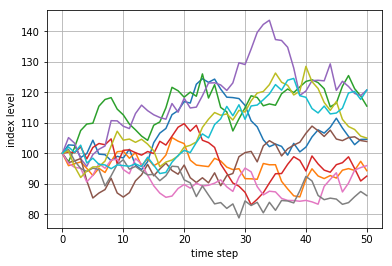

In [28]:
plt.plot(S[:, :10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')

Text(0, 0.5, 'frequency')

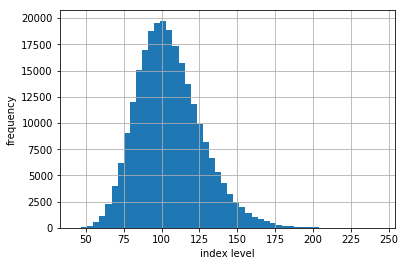

In [29]:
# 종료 시점의 주가 빈도 -> 로그분포임을 보여주는 것을 확인
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')

(0, 50000)

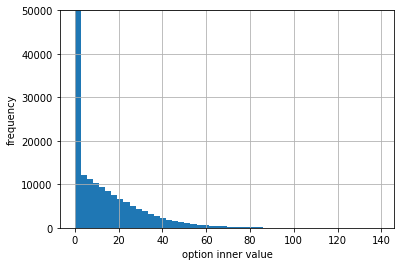

In [31]:
# 만기시의 옵션 페이오프 값의 분포
plt.hist(np.maximum(S[-1] - K, 0), bins=50)
plt.grid(True)
plt.xlabel('option inner value')
plt.ylabel('frequency')
plt.ylim(0, 50000)

In [32]:
# 만기 시 OTM 개수
sum(S[-1] < K)

134157